主任物跟副任務分別計算loss後相加，一起反向傳遞

每迭代一次load 64筆資料，算平均損失(mean_loss)，做反向傳遞優化模型，共跑500個epochs

如果val的mean_loss一直大於上一次迭代的mean_loss X次，則early stop，learning rate改0.0001，retrain X次

如果X個epoch的loss維持不變，則reduce learning rate(Schedular)

訓練十次模型，最後將十個模型的每筆預測結果做平均ensemble

In [1]:
#連接雲端
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/energy_forecast/MTL/electricity_load_commercial_buliding')


Mounted at /content/drive


In [2]:
#設定window size & prediction length
time_step = 24
predict_len = 12

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,OneHotEncoder
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from IPython import embed

#設定圖片字體
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
def saveModel(model, modelFileName, stateFileName):
    torch.save(model, modelFileName)
    torch.save(model.state_dict(), stateFileName)
    
def modelEvaluation(model, test_loader, device, is_MTL):
    model.eval()
    predictions = []
    if is_MTL == True:
        with torch.no_grad():
            for test_samples, test_main_labels, test_aux_labels in test_loader:
                test_samples = test_samples.to(device)
                test_main_labels = test_main_labels.to(device)
                test_outputs_main, test_outputs_aux = model(test_samples)
                test_outputs_main = torch.squeeze(test_outputs_main, dim=1)
                predictions.extend(test_outputs_main.cpu().detach().numpy())
    else: 
        with torch.no_grad():
            for test_samples, test_main_labels in test_loader:
                test_samples = test_samples.to(device)
                test_main_labels = test_main_labels.to(device)
                test_outputs_main = model(test_samples)
                test_outputs_main = torch.squeeze(test_outputs_main, dim=1)
                predictions.extend(test_outputs_main.cpu().detach().numpy())
    return predictions

class ArrayDataset(Dataset):
    def __init__(self, df, main_label_vec, aux_label_vec, is_MTL, transform = None):
        self.df = df
        self.main_label_vec = main_label_vec
        self.aux_label_vec = aux_label_vec
        self.is_MTL = is_MTL
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        feature = self.df[idx,:]
        main_label = self.main_label_vec[idx]
        aux_label = self.aux_label_vec[idx]

        data = torch.tensor(feature).float()
        main_label = torch.tensor(main_label).float()
        aux_label = torch.tensor(aux_label).float()
        
        if self.transform:
            data = self.transform(data)

        if self.is_MTL == True:
            return (data, main_label, aux_label)
        else:
            return (data, main_label)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


# ---------- MTL model ----------
class MTLNet(nn.Module):
    def __init__(self, input_size):
        super(MTLNet, self).__init__()
        self.input_size = input_size

        drop_prop = 0.1

        self.flatten = nn.Flatten()

        # shared network
        self.sharedNetwork = nn.Sequential(
            nn.Linear(self.input_size, 256),  
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
        )

        self.mainTaskNet = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(16, predict_len),
        )

        self.auxTaskNet = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(p=drop_prop),
            nn.Linear(16, predict_len),
        )

    def forward(self, x):
        #二維（不包含batch）轉成一維########### (batch, time step, feature) -> (batch, time step*feature)
        x = self.flatten(x)

        x_shared = self.sharedNetwork(x)
        output_main = self.mainTaskNet(x_shared)
        output_aux = self.auxTaskNet(x_shared)

        return output_main, output_aux

In [5]:
def modelMTLTrain(model, train_loader, device, optimizer, scheduler, weight, train_losses, Re):
    model.train()

    criterion_main = nn.L1Loss()
    criterion_aux = nn.L1Loss()  

    losses = []
    losses_main = []
    losses_aux = []

    if Re == True:
        lr = get_lr(optimizer)
        print(f'Re-train the model with learning rate = {lr}')

    for _, (samples, main_labels, aux_labels) in enumerate(train_loader):
        samples = samples.to(device)
        
        main_labels = main_labels.to(device)
        aux_labels = aux_labels.to(device)

        outputs_main, outputs_aux = model(samples)
        outputs_main = outputs_main.reshape(-1)
        outputs_aux = outputs_aux.reshape(-1)

        # flatten: shape(batch, predict_len) -> (batch*predict_len)
        main_labels = main_labels.reshape(-1)
        aux_labels = aux_labels.reshape(-1)

        optimizer.zero_grad()

        loss_main = criterion_main(outputs_main, main_labels)
        loss_aux = criterion_aux(outputs_aux, aux_labels)

        losses.append(loss_main.item() + loss_aux.item())
        losses_main.append(loss_main.item())
        losses_aux.append(loss_aux.item())
        loss = loss_main + torch.mul(loss_aux, weight)
        loss.backward()
        optimizer.step()

    mean_loss = sum(losses) / len(losses)
    mean_loss_main = sum(losses_main) / len(losses_main)
    mean_loss_aux = sum(losses_aux) / len(losses_aux)

    train_losses.append(mean_loss)
    
    if Re == False:
        scheduler.step(mean_loss)
    
    return train_losses, mean_loss, mean_loss_main, mean_loss_aux

def modelMTLValidate(model, val_loader, device, val_losses, valid_losses):
    model.eval()

    criterion_main = nn.L1Loss()
    criterion_aux = nn.L1Loss()  

    with torch.no_grad():
        for val_samples, val_main_labels, val_aux_labels in val_loader:
            val_samples = val_samples.to(device)
            val_main_labels = val_main_labels.to(device)
            val_aux_labels = val_aux_labels.to(device)

            val_outputs_main, val_outputs_aux = model(val_samples)
            val_outputs_main = val_outputs_main.reshape(-1)
            val_outputs_aux = val_outputs_aux.reshape(-1)

            # flatten: shape(batch, predict len) -> (batch*predict len)
            val_main_labels = val_main_labels.reshape(-1)
            val_aux_labels = val_aux_labels.reshape(-1)

            val_loss_main = criterion_main(val_outputs_main, val_main_labels)
            val_loss_aux = criterion_aux(val_outputs_aux, val_aux_labels)
            valid_losses.append(val_loss_main.item() + val_loss_aux.item())

    mean_val_losses = sum(valid_losses) / len(valid_losses)
    val_losses.append(mean_val_losses)

    return mean_val_losses


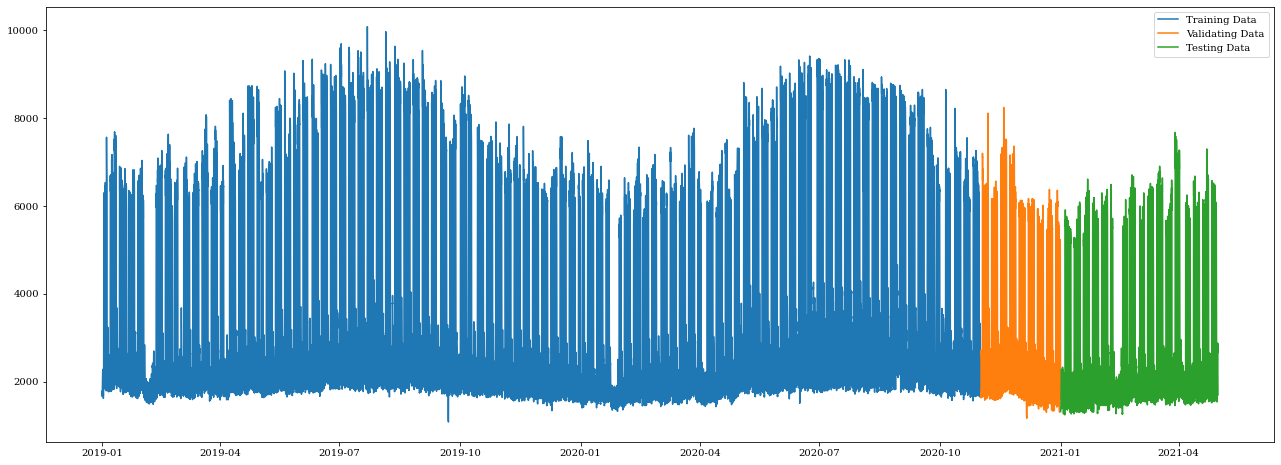

In [6]:
# dealing with data types
int_features = ['Year', 'Month', 'Day', 'Hour']
cat_features = ['Season', 'Weekend']
num_features = ['Temperature', 'Pressure', 'Humidity', 'Wind_Speed', 'Rainfall']
dtype_dict = {c: 'category' for c in cat_features}
dtype_dict.update({c: np.int32 for c in int_features})
dtype_dict.update({c: np.float32 for c in num_features})

# load data
df = pd.read_csv('data_NA_weighted.csv', dtype = dtype_dict)

# set Time (Date: yyyy-mm-dd hh:mm:ss) as index
df['Time'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str) + ' ' + \
             df['Hour'].astype(str).apply(lambda e: '{:02d}'.format(int(e)))
df['Time'] = pd.to_datetime(df['Time'], format = '%Y-%m-%d %H')
df.set_index('Time', inplace = True)
df = df.sort_index()

#%% ---------- Preprocessing ----------
# split train & test
filt = (df.index >= '2021-01-01')
df_train, df_test = df.loc[~filt], df.loc[filt]


# data imputation
df_train = df_train.fillna(method = 'ffill')
df_test = df_test.fillna(method = 'ffill')

# drop outliners (Load < 1000)
filt = (df_train['Load'] < 1000)
df_train = df_train.drop(df_train.loc[filt].index)


features = ['Year', 'Month', 'Day', 'Hour', 'Season', 'Weekend',
            'Temperature', 'Pressure', 'Humidity', 'Wind_Speed', 'Rainfall',
            ]

main_label = 'Load'
aux_label = 'Temperature'

# split X & y
X = df_train[features]
y_main = df_train[main_label]
y_aux = df_train[aux_label]

X_test = df_test[features]
y_test_main = df_test[main_label]
y_test_aux = df_test[aux_label]

# split train & validation
filt = (X.index >= '2020-11-01')
X_train, X_val = X.loc[~filt], X.loc[filt]
y_train_main, y_val_main = y_main.loc[~filt], y_main.loc[filt]
y_train_aux, y_val_aux = y_aux.loc[~filt], y_aux.loc[filt]

# plot
fig, ax = plt.subplots(figsize = (22, 8))
ax.plot(y_train_main, label = 'Training Data')
ax.plot(y_val_main, label = 'Validating Data')
ax.plot(y_test_main, label = 'Testing Data')
plt.legend()

In [7]:
# normalization (num) & one-hot encoding (cat)
num_transformer = Pipeline(steps = [('scaler', MinMaxScaler(feature_range = (-1, 1)))])
cat_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown = 'ignore'))])
preprocessor = ColumnTransformer(transformers = [('num', num_transformer, num_features),
                                                 ('cat', cat_transformer, cat_features)],
                                 remainder = 'passthrough')

X = preprocessor.fit_transform(X)
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

X_train=pd.DataFrame(X_train)
X_val=pd.DataFrame(X_val)
X_test=pd.DataFrame(X_test)


#二維轉三維 （time, feature) -> (batch, time step, feature)
def  transfer_3D(dataframe,target_main,target_aux,time_step, predict_len):  #資料數會減少time step+forecast len的數量
    data_group = []
    target_group = []
    target_aux_group=[]
    for i in range(dataframe.shape[0]-time_step-predict_len):
        data_group.append(np.array(dataframe.iloc[i:i+time_step]))
        target_group.append(np.array(target_main.iloc[i+time_step:i+time_step+predict_len]))
        target_aux_group.append(np.array(target_aux.iloc[i+time_step:i+time_step+predict_len]))
    return np.array(data_group), np.array(target_group),np.array(target_aux_group)


print("\n",X_train)

#train & test & val trans3D
X_train,y_train_main,y_train_aux = transfer_3D(X_train,y_train_main,y_train_aux,time_step, predict_len)
X_val,y_val_main,y_val_aux = transfer_3D(X_val,y_val_main,y_val_aux,time_step, predict_len)
X_test,y_test_main,y_test_aux = transfer_3D(X_test,y_test_main,y_test_aux,time_step, predict_len)


# torch: Dataset, DataLoader (MTL)
train_val_dataset_MTL = ArrayDataset(X, y_main, y_aux, True)
train_dataset_MTL = ArrayDataset(X_train, y_train_main, y_train_aux, True)
val_dataset_MTL = ArrayDataset(X_val, y_val_main, y_val_aux, True)
test_dataset_MTL = ArrayDataset(X_test, y_test_main, y_test_aux, True)
print(f'training size: {len(train_dataset_MTL)}, validation size: {len(val_dataset_MTL)}, test size:{len(test_dataset_MTL)}')

batch_size = 64
train_val_loader = DataLoader(dataset = train_val_dataset_MTL, batch_size = batch_size, shuffle = True)
train_loader = DataLoader(dataset = train_dataset_MTL, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset_MTL, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset_MTL, batch_size = batch_size, shuffle = False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


              0         1         2         3         4    5    6    7    8   \
0     -0.486486  0.862068  0.920000 -0.587629 -0.986577  0.0  0.0  0.0  1.0   
1     -0.486486  0.849140  0.920000 -0.567010 -0.973154  0.0  0.0  0.0  1.0   
2     -0.486486  0.823277  0.920000 -0.525773 -0.986577  0.0  0.0  0.0  1.0   
3     -0.486486  0.814655  0.920000 -0.546392 -1.000000  0.0  0.0  0.0  1.0   
4     -0.493243  0.814655  0.920000 -0.608247 -0.986577  0.0  0.0  0.0  1.0   
...         ...       ...       ...       ...       ...  ...  ...  ...  ...   
16071  0.020270  0.400864  0.253333 -0.670103 -1.000000  0.0  0.0  1.0  0.0   
16072  0.013514  0.405174  0.333333 -0.814433 -1.000000  0.0  0.0  1.0  0.0   
16073  0.020270  0.400864  0.333333 -0.690722 -1.000000  0.0  0.0  1.0  0.0   
16074  0.040541  0.383621  0.120000 -0.649485 -1.000000  0.0  0.0  1.0  0.0   
16075  0.027027  0.375000  0.120000 -0.670103 -1.000000  0.0  0.0  1.0  0.0   

        9    10      11    12    13    14  
0    

In [8]:
print(X_train.shape,y_train_main.shape,y_train_aux.shape)
print(X_val.shape,y_val_main.shape,y_val_aux.shape)
print(X_test.shape,y_test_main.shape,y_test_aux.shape)


(16040, 24, 15) (16040, 12) (16040, 12)
(1423, 24, 15) (1423, 12) (1423, 12)
(2844, 24, 15) (2844, 12) (2844, 12)


input size 360
Ensemble Step 1
Epoch 10: average training loss is 751.62, validation loss is 13992.98, main task loss: 749.73, auxiliary task loss: 1.89
Epoch 20: average training loss is 690.73, validation loss is 2994.41, main task loss: 688.91, auxiliary task loss: 1.82
Epoch 30: average training loss is 661.34, validation loss is 5449.42, main task loss: 659.58, auxiliary task loss: 1.76
Epoch 40: average training loss is 648.26, validation loss is 1799.04, main task loss: 646.53, auxiliary task loss: 1.73
Epoch 50: average training loss is 647.40, validation loss is 2609.47, main task loss: 645.66, auxiliary task loss: 1.73
Epoch 00058: reducing learning rate of group 0 to 2.5000e-03.
Epoch 60: average training loss is 618.45, validation loss is 1104.16, main task loss: 616.85, auxiliary task loss: 1.60
Epoch 70: average training loss is 613.01, validation loss is 871.54, main task loss: 611.45, auxiliary task loss: 1.56
Epoch 00075: reducing learning rate of group 0 to 1.2500e-04

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.,
        14000., 16000., 18000.]), <a list of 11 Text major ticklabel objects>)

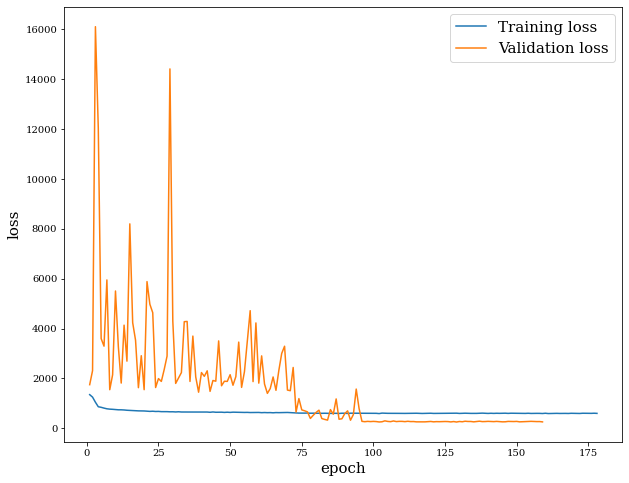

In [9]:
input_size = X_train.shape[1]*X_train.shape[2]
print(f'input size {input_size}')

num_of_ensembles = 2  #10 #模型總共跑幾次，最後會將所有模型的output平均
epochs = 300  #500 
warm_up = 50
weight = 500 #副任務的predict loss weight
model_file_names = []

#training
for ensemble in range(num_of_ensembles):
    print(f'Ensemble Step {ensemble + 1}')
    train_losses = []
    val_losses = []
    early_stop = False
    model_saving = True

    model = MTLNet(input_size).to(device)

    prev_mean_val_losses = 0
    count = 0
    
    training_over = False

    learning_rate = 0.05
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.99), eps = 1e-08, weight_decay = 0.0001, amsgrad = False)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.05, patience = 5, verbose = True)
    
    for epoch in np.arange(epochs):
        train_losses, mean_loss, mean_loss_main, mean_loss_aux =  modelMTLTrain(model, train_loader, device, optimizer, scheduler, weight, train_losses, False)
        valid_losses = []

        mean_val_losses = modelMTLValidate(model, val_loader, device, val_losses, valid_losses)        
        if epoch >= warm_up:
            if epoch == warm_up:
                prev_mean_val_losses = 9999999
            elif mean_val_losses > prev_mean_val_losses:
                count += 1
            else:
                prev_mean_val_losses = mean_val_losses
                count = 0
                model_saving = True

            if count >= 30:
                print('================ Early stop ================')
                print(f'mean validation loss: {prev_mean_val_losses:.2f}')
                early_stop = True
                count = 0
                training_over = True
                break        

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}: average training loss is {mean_loss:.2f}, validation loss is {mean_val_losses:.2f}, main task loss: {mean_loss_main:.2f}, auxiliary task loss: {mean_loss_aux:.2f}')
    
    if training_over:
        learning_rate = 0.0001
        optimizer = optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.99), eps = 1e-08, weight_decay = 0.0001, amsgrad = False)        

        for e in np.arange(20):
            train_losses, mean_loss, mean_loss_main, mean_loss_aux =  modelMTLTrain(model, train_loader, device, optimizer, scheduler, weight, train_losses, True)
            print(f'Epoch {e+1}: average training loss is {mean_loss:.2f}, main task loss: {mean_loss_main:.2f}, auxiliary task loss: {mean_loss_aux:.2f}')

        now = datetime.now()
        timestamp = now.strftime("%y_%m_%d_%H_%M_%S")
        model_filePath = f'model/model_{epoch + 1}_{timestamp}.pth'
        print(f"Saving the model...model name: {model_filePath}")
        state_dict_filePath = f'model/state_dict_ensemble_{epoch + 1}_{timestamp}.pth'
        saveModel(model, model_filePath, state_dict_filePath)   
        
        model_file_names.append(model_filePath)

fig, ax = plt.subplots(figsize = (10, 8))
train_losses = train_losses[1:]

ax.plot(range(1, len(train_losses)+1), train_losses, label = 'Training loss')
ax.plot(range(1, len(val_losses)+1), val_losses, label = 'Validation loss')
plt.legend(fontsize=15)
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("loss", fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


In [15]:
# testing
print()
ensemble_MTL_predictions = []
MTL_MAE_list = []
MTL_MSE_list = []
MTL_RMSE_list = []

for f in model_file_names:
    model = torch.load(f)
    MTL_predictions = modelEvaluation(model, test_loader, device, True)
    # print(MTL_predictions)
    MTL_MAE = mean_absolute_error(y_test_main, MTL_predictions)
    MTL_MSE = mean_squared_error(y_test_main, MTL_predictions)
    MTL_RMSE = np.sqrt(MTL_MSE)
    
    MTL_MAE_list.append(MTL_MAE)
    MTL_MSE_list.append(MTL_MSE)
    MTL_RMSE_list.append(MTL_RMSE)
    print(f'MTL model {f}, MAE: {MTL_MAE:.2f}, MSE: {MTL_MSE:.2f}, RMSE: {MTL_RMSE:.2f}')
    
    ensemble_MTL_predictions.append(MTL_predictions)

#print number of model的MAE平均   
print(f'Average Performance for {len(MTL_MAE_list)} MTL models is: MAE = {np.mean(MTL_MAE_list):.2f}, MSE = {np.mean(MTL_MSE_list):.2f}, RMSE = {np.mean(MTL_RMSE_list):.2f}')
print(f'Performance Standard Deviation for {len(MTL_MAE_list)} MTL models is: MAE = {np.std(MTL_MAE_list):.2f}, MSE = {np.std(MTL_MSE_list):.2f}, RMSE = {np.std(MTL_RMSE_list):.2f}')
# y_test_main_time=y_test_main

#print number of model的predict output平均
final_MTL_predictions = [np.mean(MTL_predictions,axis=0) for MTL_predictions in zip(*ensemble_MTL_predictions)] #list 5d -> 1d(zip欄列互換)把predction output len & ensemble次數做平均
# y_test_main = [np.mean(i) for i in y_test_main]  # shape(281, 5) -> (281, 1) #add(axis=0)

MTL_MAE = mean_absolute_error(y_test_main, final_MTL_predictions)
MTL_MSE = mean_squared_error(y_test_main, final_MTL_predictions)
MTL_RMSE = np.sqrt(MTL_MSE)
print(f'Ensemble {len(ensemble_MTL_predictions)} MTL Model performance: MAE = {MTL_MAE:.2f}, MSE = {MTL_MSE:.2f}, RMSE = {MTL_RMSE:.2f}')

# final_MTL_predictions = pd.DataFrame(final_MTL_predictions)
# #final_MTL_predictions = final_MTL_predictions.set_index(y_test_main_time.index.get_level_values('date'))
# fig, ax = plt.subplots(figsize = (22, 8))
# ax.plot(y_test_main, label = 'Real Load')
# ax.plot(final_MTL_predictions, label = 'Predicted Load')
# plt.legend(fontsize=30)
# ax.set_xlabel("time", fontsize=30)
# ax.set_ylabel("Load", fontsize=30)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)




MTL model model/model_114_22_07_29_04_56_24.pth, MAE: 300.40, MSE: 337559.40, RMSE: 581.00
MTL model model/model_159_22_07_29_05_05_22.pth, MAE: 288.03, MSE: 303096.99, RMSE: 550.54
Average Performance for 2 MTL models is: MAE = 294.22, MSE = 320328.20, RMSE = 565.77
Performance Standard Deviation for 2 MTL models is: MAE = 6.19, MSE = 17231.21, RMSE = 15.23
Ensemble 2 MTL Model performance: MAE = 286.68, MSE = 307701.37, RMSE = 554.71


In [ ]:
# tmp = []
# for i in range(len(x)):
#   ans = np.mean(x[0],axis=0)
#   tmp.append(ans)
# tmp = np.array(tmp)
# tmp.shape

In [ ]:
# pred_plot=pd.read_csv("all_cut.csv")

In [ ]:
# filt=pred_plot.iloc[:,4]>40000
# pred_plot.loc[filt]

In [ ]:
# fig, ax = plt.subplots(figsize = (22, 8))
# ax.plot(pred_plot.iloc[:,1], label = '3-hour ahead')
# ax.plot(pred_plot.iloc[:,2], label = '6-hour ahead')
# ax.plot(pred_plot.iloc[:,3], label = '12-hour ahead')
# ax.plot(pred_plot.iloc[:,4], label = '24-hour ahead')
# ax.plot(pred_plot.iloc[:,5], label = 'true values')
# #ax.plot(pred_plot.iloc[:,6], label = '144-hour ahead')
# #ax.plot(pred_plot.iloc[:,7], label = 'true values')
# plt.legend(fontsize=17,loc='upper left')
# ax.set_xlabel("time", fontsize=30)  
# ax.set_ylabel("Load", fontsize=30)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.show()
